## A Comparison of NBA Player Shooting Styles
By Ashley Radford

Fetching and using nba data from stats.nba.com to analyze the different types of shooters. We will be categorizing the players by how greatly the different styles of shooting, determined from an iteration of different non-negative matrix factorizations, weigh in on a player's own shooting pattern. After, players and their coefficients will be compared to one another and then grouped accordingly through a hierarchical clustering approach.

### Preparing data
We will once again start by checking which season we are working with. Then, using the same `get_nba_data()` function from the helper_basketball module as before, we will begin by downloading all the current teams and current players, regarding our chosen season.

In [1]:
# necessary importations
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math

import helper_basketball as h
import sklearn.decomposition as skld # for non-negative matrix factorization
import seaborn as sns

from numpy import linalg as LA # to compute Frobenious norm
from scipy.cluster.hierarchy import dendrogram, linkage # for clustering

In [2]:
# choose season and year
# note: current_year is 20BB when latest_season is 20AA-BB
current_year = 2017
latest_season = '2016-17'

In [3]:
# get all 2016-17 teams
teams_params = {'LeagueID':'00'}
teams = h.get_nba_data('commonTeamYears', teams_params).set_index('TEAM_ID')

# setting up series types
teams.ABBREVIATION = teams.ABBREVIATION.astype('category')
teams.MIN_YEAR     = teams.MIN_YEAR.astype('int')
teams.MAX_YEAR     = teams.MAX_YEAR.astype('int')

# grabbing only current teams
teams = teams[(teams.MIN_YEAR <= (current_year-1)) & (teams.MAX_YEAR >= current_year)]
teamids = teams.index.values

# get all 2016-17 players
players_params = {'LeagueID':'00', 'Season': latest_season, 'IsOnlyCurrentSeason': '0'}
players = h.get_nba_data('commonallplayers', players_params).set_index('PERSON_ID')
players = players[players.TEAM_ID.isin(teamids)]
playerids = players.index.values

In [4]:
# checking teams
teams.head()

,LEAGUE_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION
TEAM_ID,,,,
1610612737,00,1949,2018,ATL
1610612738,00,1946,2018,BOS
1610612739,00,1970,2018,CLE
1610612740,00,2002,2018,NOP
1610612741,00,1966,2018,CHI


In [5]:
# checking players
players.head()

,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH
PERSON_ID,,,,,,,,,,,,,
203518,"Abrines, Alex",Alex Abrines,1,2016,2018,alex_abrines,1610612760,Oklahoma City,Thunder,OKC,thunder,Y,00
203112,"Acy, Quincy",Quincy Acy,1,2012,2018,quincy_acy,1610612751,Brooklyn,Nets,BKN,nets,Y,11
203500,"Adams, Steven",Steven Adams,1,2013,2018,steven_adams,1610612760,Oklahoma City,Thunder,OKC,thunder,Y,00
201167,"Afflalo, Arron",Arron Afflalo,1,2007,2017,arron_afflalo,1610612758,Sacramento,Kings,SAC,kings,Y,00
201582,"Ajinca, Alexis",Alexis Ajinca,1,2008,2017,alexis_ajinca,1610612740,New Orleans,Pelicans,NOP,pelicans,Y,01


In [6]:
players

,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH
PERSON_ID,,,,,,,,,,,,,
203518,"Abrines, Alex",Alex Abrines,1,2016,2018,alex_abrines,1610612760,Oklahoma City,Thunder,OKC,thunder,Y,00
203112,"Acy, Quincy",Quincy Acy,1,2012,2018,quincy_acy,1610612751,Brooklyn,Nets,BKN,nets,Y,11
203500,"Adams, Steven",Steven Adams,1,2013,2018,steven_adams,1610612760,Oklahoma City,Thunder,OKC,thunder,Y,00
201167,"Afflalo, Arron",Arron Afflalo,1,2007,2017,arron_afflalo,1610612758,Sacramento,Kings,SAC,kings,Y,00
201582,"Ajinca, Alexis",Alexis Ajinca,1,2008,2017,alexis_ajinca,1610612740,New Orleans,Pelicans,NOP,pelicans,Y,01
202332,"Aldrich, Cole",Cole Aldrich,1,2010,2017,cole_aldrich,1610612750,Minnesota,Timberwolves,MIN,timberwolves,Y,01
200746,"Aldridge, LaMarcus",LaMarcus Aldridge,1,2006,2018,lamarcus_aldridge,1610612759,San Antonio,Spurs,SAS,spurs,Y,00
202730,"Allen, Lavoy",Lavoy Allen,1,2011,2016,lavoy_allen,1610612754,Indiana,Pacers,IND,pacers,Y,01
2754,"Allen, Tony",Tony Allen,1,2004,2017,tony_allen,1610612763,Memphis,Grizzlies,MEM,grizzlies,Y,00


### Getting the shots data

We will now be getting the shooting data a little differently than in `widgets_presentation.ipynb`. We will follow the data collection procedure described in this paper: https://arxiv.org/abs/1401.0942. The data consists of all shots attempted by anyone during the regular season of the chosen "latest season." The shots are filtered in the 50' x 35' offensive court then only those who made more than 50 are included.

This data collection is time expensive, and so we will only do it once for the chosen "latest season." Each run through will create a pickle file containing the grabbed data. We want to first check if we already have that file, and so the cell below will be doing just that. If it tells us that we must run the next cell be sure to uncomment out the cell that is grabbing the data and run.

In [7]:
'''
# run me if no pickle file for selected season
shots_params = {'PlayerID':'201939',
                'PlayerPosition':'',
                'Season': latest_season,
                'ContextMeasure':'FGA',
                'DateFrom':'',
                'DateTo':'',
                'GameID':'',
                'GameSegment':'',
                'LastNGames':'0',
                'LeagueID':'00',
                'Location':'',
                'Month':'0',
                'OpponentTeamID':'0',
                'Outcome':'',
                'Period':'0',
                'Position':'',
                'RookieYear':'',
                'SeasonSegment':'',
                'SeasonType':'Regular Season',
                'TeamID':'0',
                'VsConference':'',
                'VsDivision':''}

shotdf = []
for p in playerids:
    # get player p's data
    shots_params['PlayerID'] = p
    shotdata = h.get_nba_data('shotchartdetail', shots_params)
    
    # subset columns
    sc = shotdata.loc[:,'SHOT_DISTANCE':'SHOT_MADE_FLAG']
    sc.drop('SHOT_ATTEMPTED_FLAG', axis=1)

    # filter shots to 31 feet from end zone
    sc = sc.loc[sc.LOC_Y < (31*12)]
 
    # keep data with more than 50 shots
    if sc.SHOT_MADE_FLAG.sum() > 50:
        sc['PlayerID'] = p
        shotdf += [sc]
        
allshots = pd.concat(shotdf)

pickle.dump(allshots, open('allshots' + str(latest_season) + '.pkl', 'wb'))
''';

In [8]:
# getting allshots data from pickle file
allshots = pickle.load(open('allshots' + str(latest_season) + '.pkl', 'rb'))
# can choose to make allshots to be allmade
# allmade = allshots.loc[allshots.SHOT_MADE_FLAG==1]

# want players who make the shot requirements
player_ids = allshots.PlayerID.unique()
num_players = player_ids.size
allshots.head()

,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,PlayerID
0,26,-148,214,1,0,1713
1,27,-155,228,1,0,1713
2,1,-14,-1,1,1,1713
3,20,-196,61,1,0,1713
4,24,217,110,1,0,1713


### Setting up court details

We want to limit X and Y locations to 35 feet (length-wise) by 50 feet (width-wise). This should be a little under half of the court. Data contains more of the court, as seen below:

In [9]:
pd.DataFrame([allshots.LOC_X.describe(), 
              allshots.LOC_Y.describe()])

,count,mean,std,min,25%,50%,75%,max
LOC_X,202152.0,-0.246023,110.854474,-250.0,-53.0,0.0,52.0,250.0
LOC_Y,202152.0,85.151084,88.685183,-51.0,7.0,46.0,164.0,370.0


We are now going to divide the court up into bins, and, for each player, count number of shots that fall into each bin. Then, we will vectorize the bins into a row vector.

We now want to use kernel smoothing to smooth out our players' histograms. We will then take these smoothed out histograms and have them normalized to sum to one to create an empirical distribution function. We must do this because each player has attempted a different amount of shots and we want each player standardized.

`h.ndimage.filters.gaussian_filter()` is the name of the kernel smoothing function (see helper_basketball.py).

In [10]:
# bin edge definitions in inches
xedges = (np.linspace(start=-25, stop=25, num=151, dtype=np.float)) * 12
yedges = (np.linspace(start= -4, stop=31, num=106, dtype=np.float)) * 12

# number of bins is one less than number of edges
nx = xedges.size - 1
ny = yedges.size - 1

# 2d histogram containers for binned counts and smoothed binned counts
all_smooth = {}
all_counts = {}

# data matrix: players (row) by vectorized 2-d court locations (column)
for i, one in enumerate(allshots.groupby('PlayerID')):
    
    # pid is player and pdf is the rows associated to the player
    pid, pdf = one
    
    # h.bin_shots, see below for its function performance example
    tmp1, xedges, yedges = h.bin_shots(pdf, bin_edges=(xedges, yedges), density=True, sigma=2)
    tmp2, xedges, yedges = h.bin_shots(pdf, bin_edges=(xedges, yedges), density=False)
    
    # vectorize and store into dictionary
    all_smooth[pid] = tmp1.reshape(-1)
    all_counts[pid] = tmp2.reshape(-1)

A closer look at what `h.bin_shots()` is doing...

In [11]:
# an example showing how h.bin_shots works  
bins = ([1,2,3,4,5],[1,2,3,4])
x = [1,1.7,4,5]
y = [2,2.3,2.5,1]
a,b,c = np.histogram2d(x,y, bins)

print(a,'\n')
print(a.reshape(-1),'\n')
print(b,'\n')
print(c)

[[0. 2. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 0.]] 

[0. 2. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 

[1. 2. 3. 4. 5.] 

[1. 2. 3. 4.]


### Non-negative matrix factorization (NMF)

Now that we have all of our player data set up and in bins we will perform non-negative matrix factorization. Given some matrix $X$ is $p\times n$ matrix, NMF computes the following factorization:
$$ \min_{W,H} \| X - WH \|_F\\
\text{ subject to } W\geq 0,\ H\geq 0, $$
where $W$ is ${p\times r}$ matrix and $H$ is ${r\times n}$ matrix.

NMF is a unique factorization in that all values are non-negative; hence, it is used for the factorization of $X$ into bases consist of non-negative values. We will create our own matrix `X` which will consist of columns that represent the vectorized smoothed densities of each player.
In other words, this is a pxn matrix where p is number of bins constructed from a 35 by 50 portion of the nba basketball court (we have a total of 15750 bins). Each bin contains the number of shots made (per player) in that bin area. And n is the number of players. Thus, `X` is a 15750x362 matrix where each column represents a unique player and their shot count for each bin. 

In [12]:
# creating our X matrix
X = np.stack(all_smooth.values()).T

We have the non-negative $r$-bases vectors in matrix `W` (think of the bases as different shooting styles). Columns in matrix `H` are the vector of coefficients. Each coefficient in a column says how important each of the bases (columns of `W`) are. Bascially, they are weighting the shooting styles for each player. In the next section we will be deciding on the number of bases we would like to have.

### Base Vector Experimentation
The following code will be experimenting with different number of `n_components` to change the number of bases vectors. The different number of bases vectors will then be visualized.

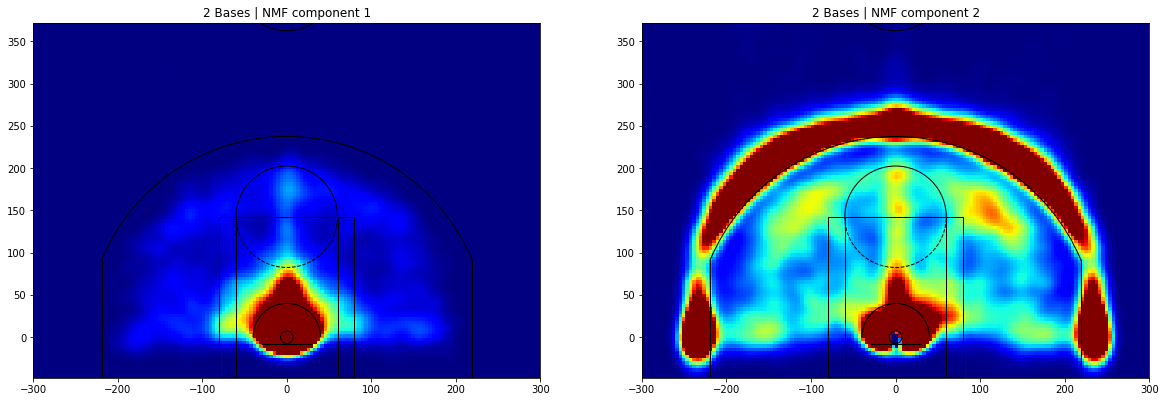

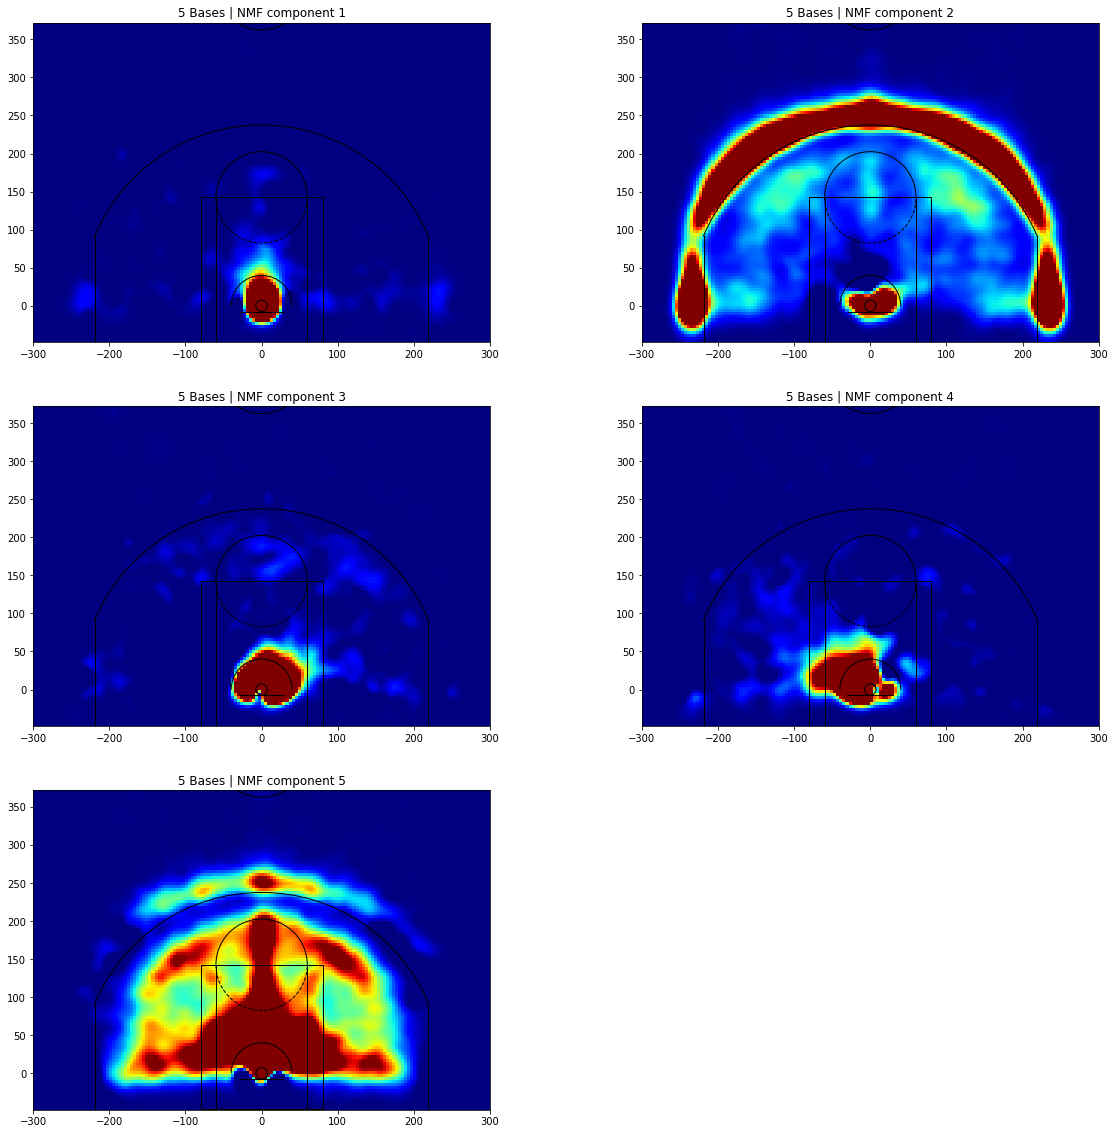

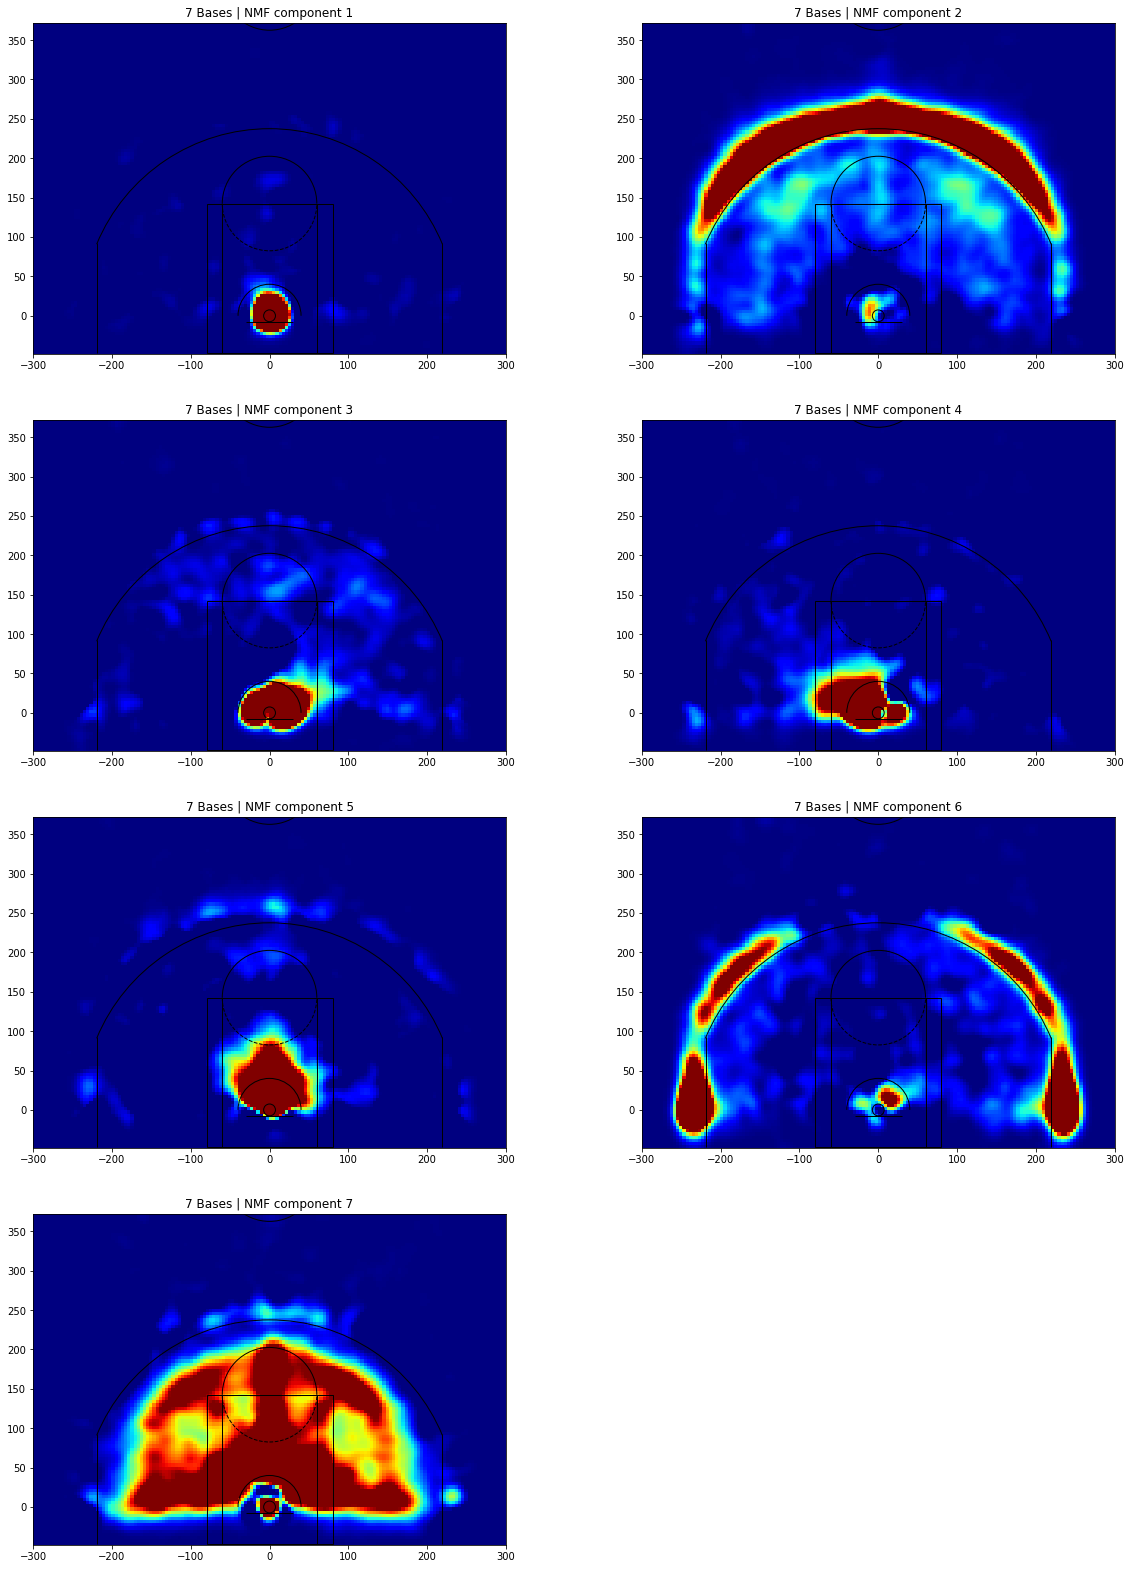

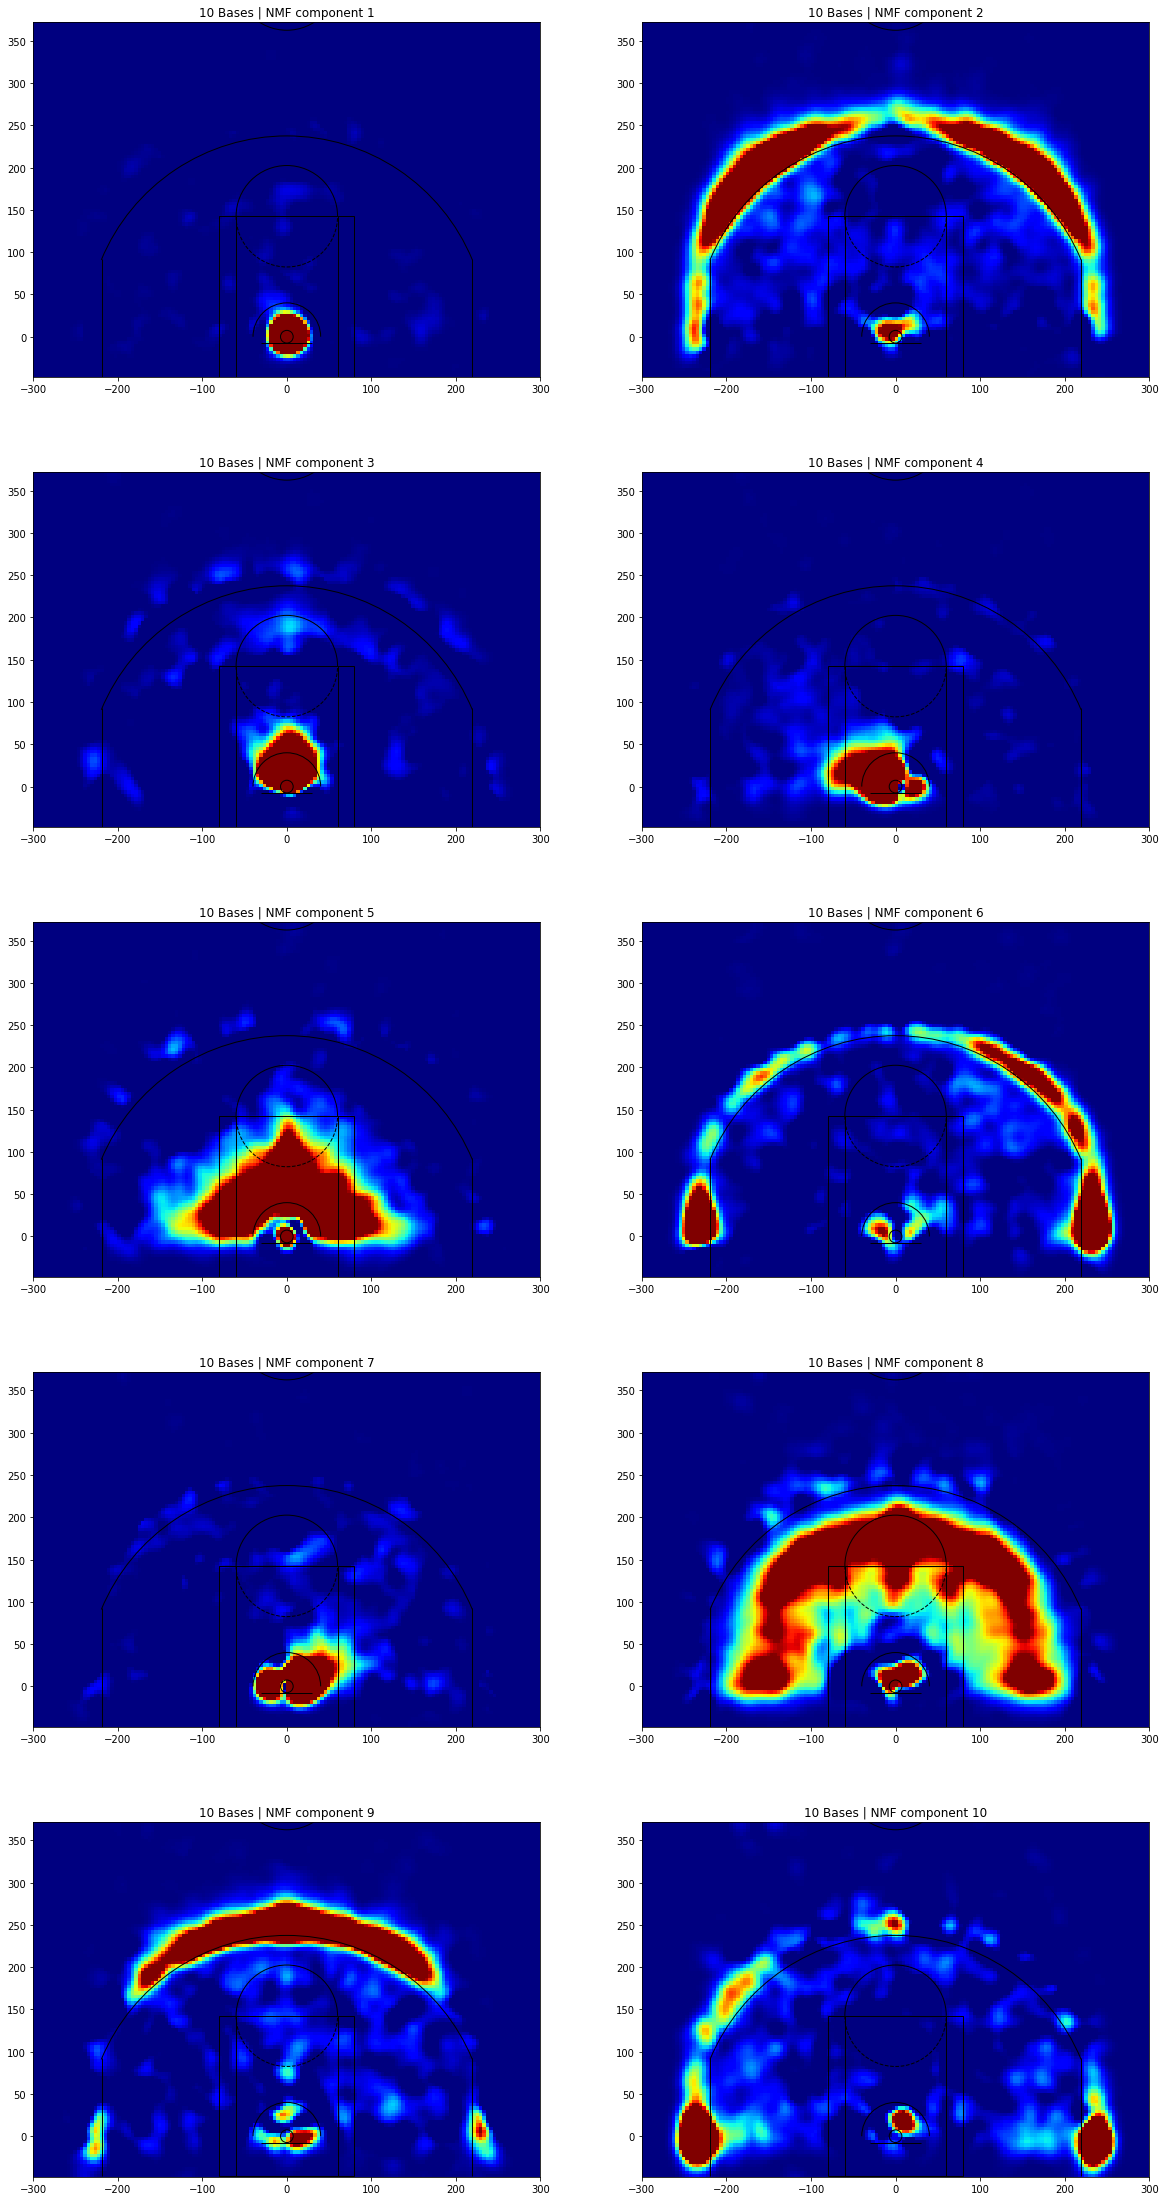

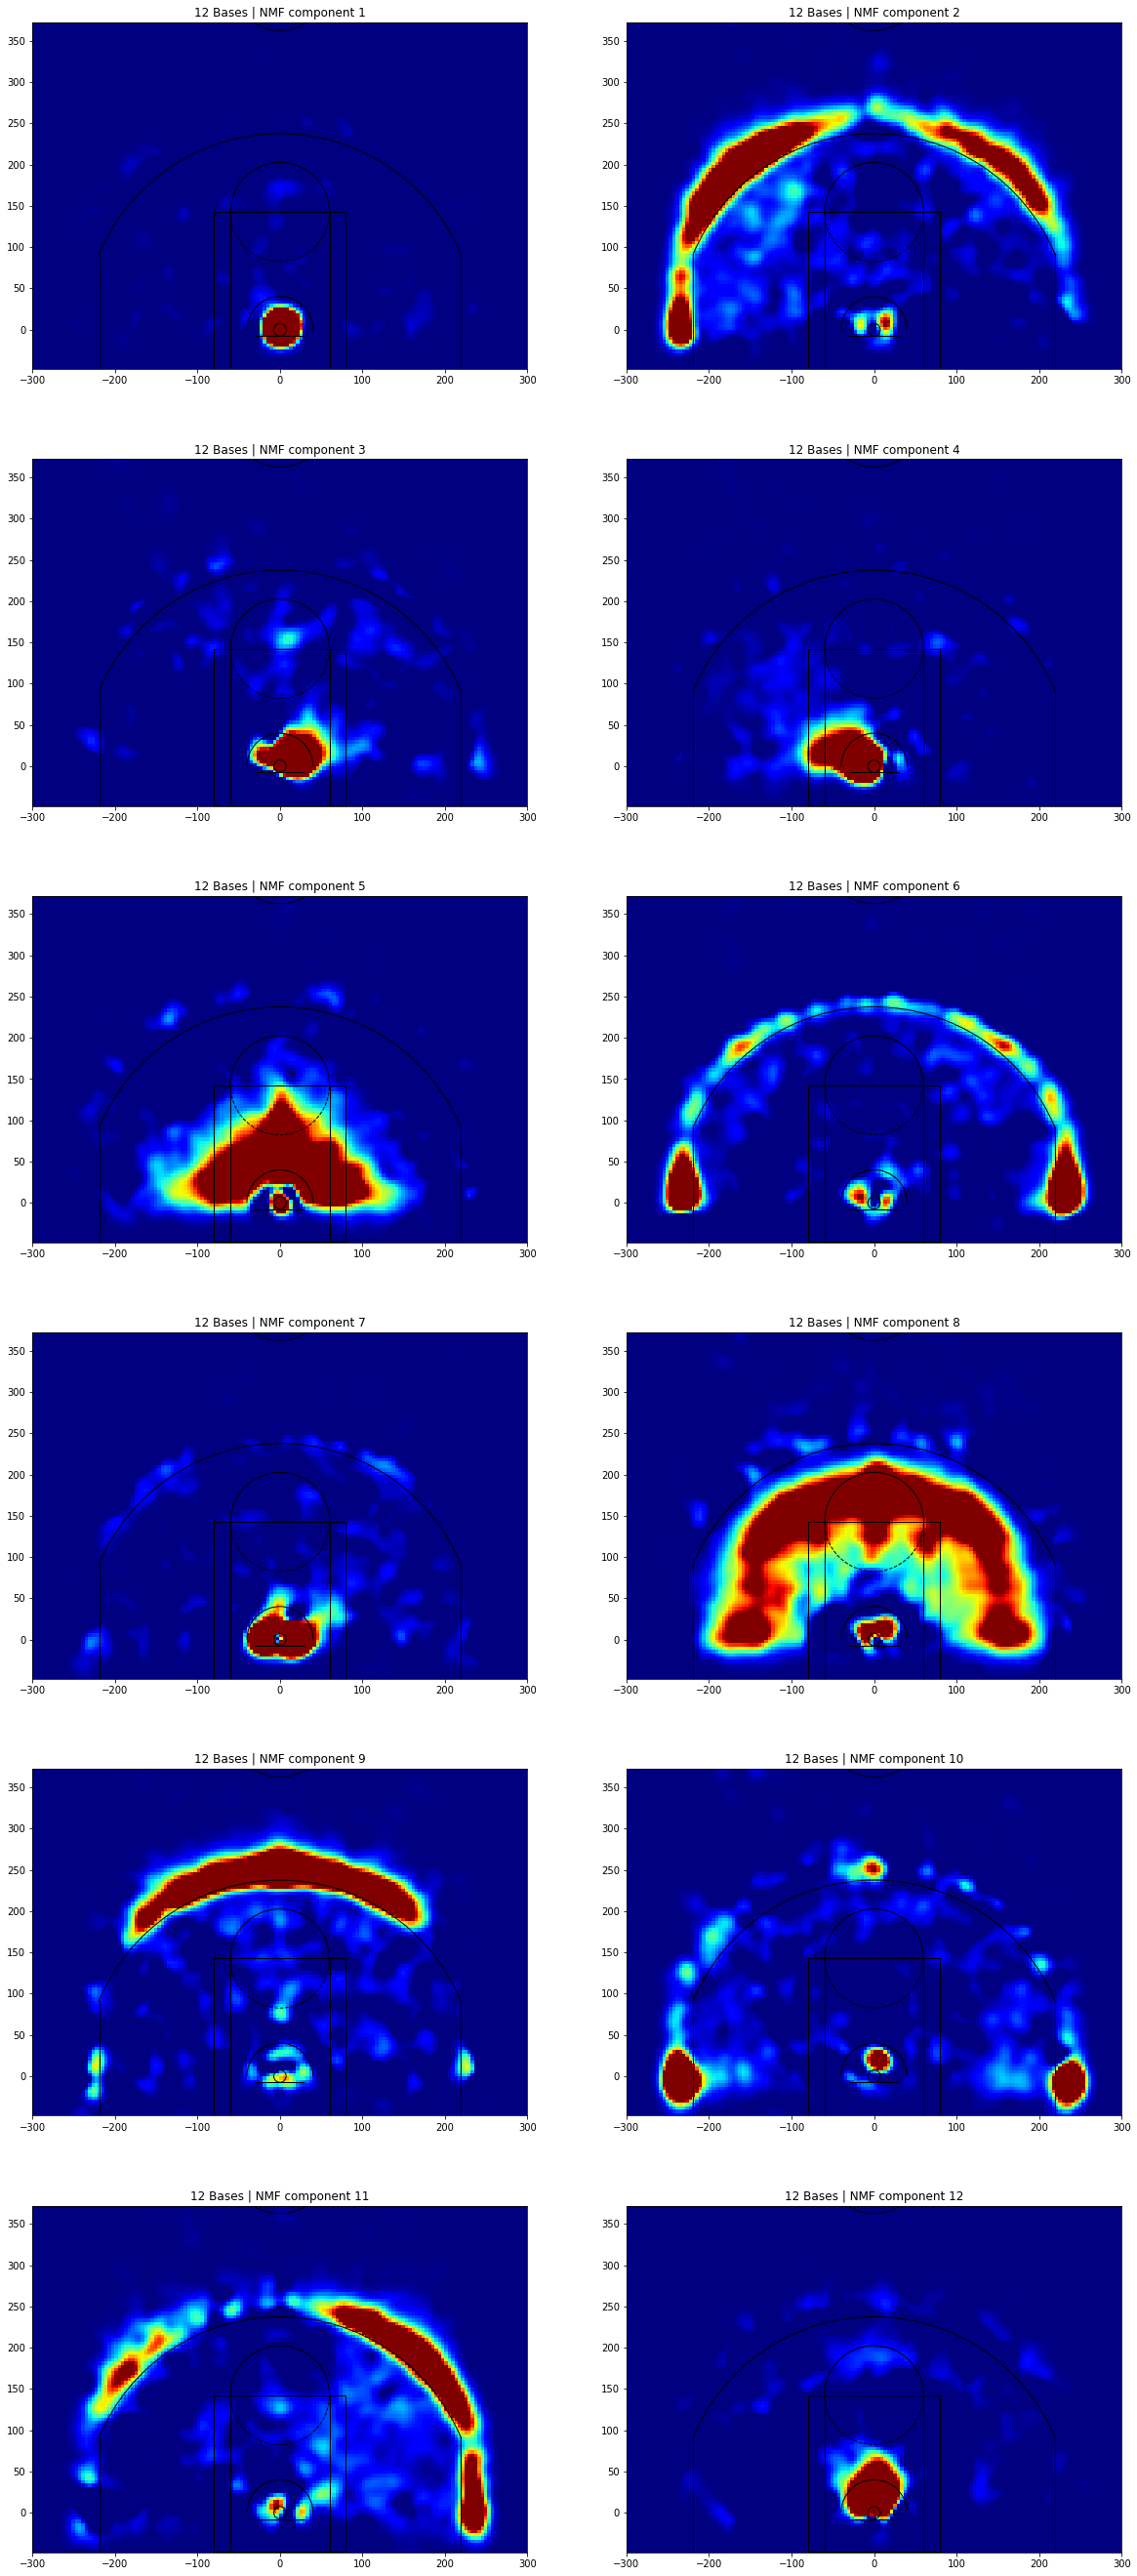

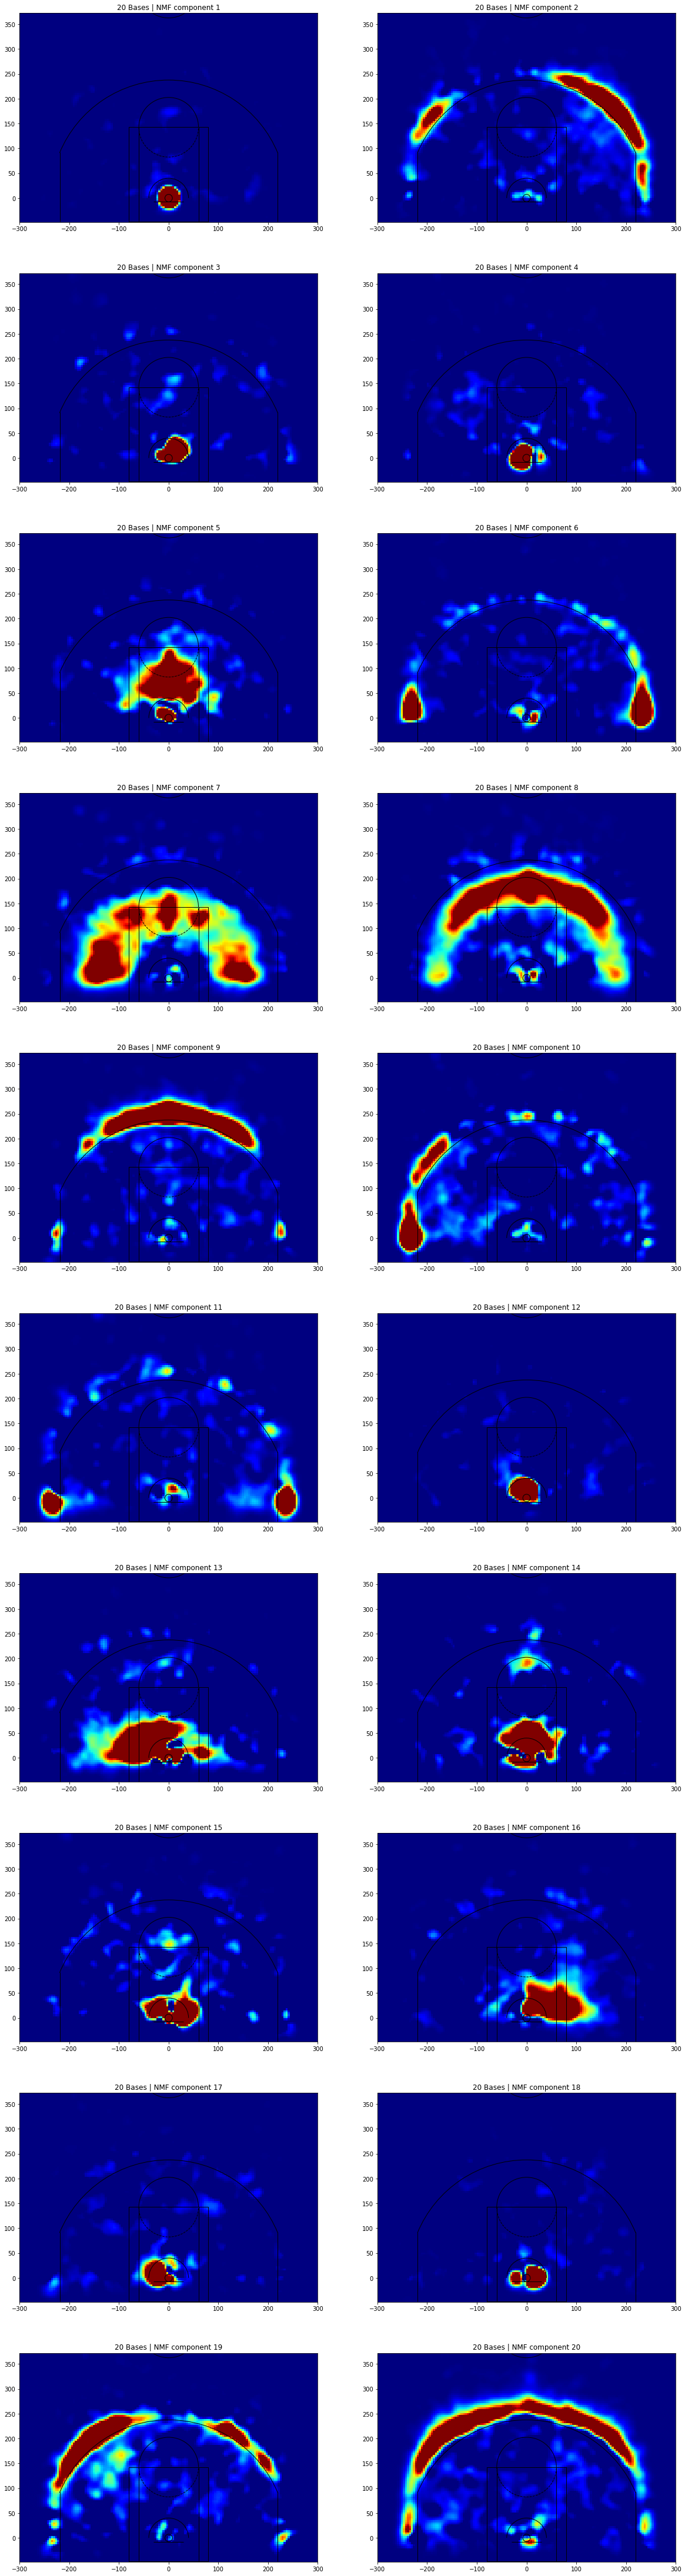

In [13]:
# changing the number of base vectors
# performing non negative matrix factorization based on diffferent r values
def non_negative_matrix(n_components, train_data):
    model = skld.NMF(n_components=n_components, init='nndsvda', max_iter=500, random_state=0)
    W = model.fit_transform(train_data)
    H = model.components_
    return W, H

num_r_bases = [2,5,7,10,12,20]
for r in num_r_bases:
    W, H = non_negative_matrix(r, X)
    fig, ax = plt.subplots(math.ceil(r/2), 2, figsize=(20,r*4))
    for i, axi in enumerate(ax.flatten()):                      # note: W is tuple with each component being a row
        if i < r:                                               # wont plot extra odd numbered plot in row
            h.plot_shotchart(W[:,i], xedges, yedges, ax=axi)    # each column of W, which is an r base vector
            axi.set_title(str(r) + ' Bases | NMF component ' + str(i+1))
        else:
            fig.delaxes(ax[math.ceil(r/2)-1, 1])                # deletes extra unneeded r plot

In [14]:
# computing the norm of the difference
r_values = [1,5,7,10,13,15,17,20,25,30]
error_norm = []
for r in r_values:
    W,H = non_negative_matrix(n_components = r, train_data = X)
    error_norm.append(LA.norm(X-np.matmul(W,H),'fro'))

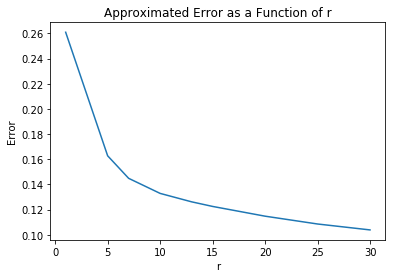

In [15]:
# plotting the approximated error as a function of r
plt.plot(r_values, error_norm)
plt.title('Approximated Error as a Function of r')
plt.xlabel('r')
plt.ylabel('Error')
plt.show()

#### The rest of the notebook relies on the fact that `current_year` is 2017 and `latest_season` is '2016-17.'

When using only 2 or 7 r components there seems to be a lack of diversity of shooting modes, this suggests that the value of r is too small. Now, when we go past 10 r components we don't seem to be getting any new information, the bases seem to be duplicated. This indicates that r is too large. This is verified when looking at the approximate error plotted against the values of r. We see a sort of elbow at the value of 10. And since 10 gives us an adequate amount of information without losing any diversity, this seems to be around the value of r that we would want. Let's examine some star players' shooting styles by looking at the coefficients (after we set our r to 10).

In [16]:
# selecting star players
stars = 'LeBron James|Brook Lopez|Tyson Chandler|Marc Gasol|Tony Parker|Kyrie Irving|Stephen Curry|James Harden|Steve Novak'
starids = players[players.DISPLAY_FIRST_LAST.str.contains(stars)].reindex(player_ids).dropna() 
# reindex ensures that we have shot data for the selected players

In [17]:
# new non negative matrix factorization
W, H = non_negative_matrix(10, X)

# Hd holds the coefficients
Hd = pd.DataFrame(H, columns=all_smooth.keys())
star_coeff = Hd.loc[:,starids.index.values]
star_coeff.columns = starids.DISPLAY_FIRST_LAST
star_coeff.T

,0,1,2,3,4,5,6,7,8,9
DISPLAY_FIRST_LAST,,,,,,,,,,
Tyson Chandler,0.111630,0.000000,0.027282,0.010768,0.000000,0.000000,0.034619,0.000000,0.000000,0.000000
Tony Parker,0.012649,0.000000,0.003161,0.021800,0.013497,0.013194,0.017432,0.016279,0.000000,0.002829
LeBron James,0.054130,0.013394,0.000000,0.021703,0.005867,0.000000,0.008174,0.006418,0.003715,0.003882
Marc Gasol,0.008519,0.005522,0.005605,0.002494,0.021602,0.000000,0.004574,0.014310,0.015897,0.000000
Brook Lopez,0.013173,0.012208,0.007934,0.006077,0.024254,0.000000,0.014694,0.000876,0.012677,0.004906
James Harden,0.010244,0.015804,0.015427,0.022541,0.006206,0.000875,0.001153,0.002632,0.026452,0.000000
Stephen Curry,0.009250,0.021966,0.018736,0.006219,0.000023,0.003530,0.007474,0.005048,0.012021,0.005337
Kyrie Irving,0.020618,0.013417,0.002931,0.015087,0.005779,0.004031,0.010586,0.011561,0.004585,0.005546


### Comparing players' shooting styles

Here, we compare the players' shooting styles to each other directly. We are interested in the pairwise correlation between shooting patterns. Let $X_i$ represent the column in the smoothed shooting pattern for player $i$. Then, we will compute $ R = [\text{Cor} (X_i, X_j)]_{i,j} $ for all player combinations $i,j\in\{1,2,\dots,362\}$. 

Since the function that calculates the correlation matrix, `np.corrcoef()`, calculates the correlation based on the assumption that each row is an observation, we will want to transpose the matrix X in order for this to hold true as each column represents the shooting pattern for each player. Thus, each columns represents an observation. We can do this transpose inside the function by setting the parameter `rowvar` equal to zero. If we were to tranpose X beforehand manually, we could simply use `np.corrcoef()` as is. Now, the correlation matrix R should have a dimension of 362x362.
 
We will then visualize matrix $R$ with [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function. The two pairs of players with highest similarities (positive correlation) and the two pairs with lowest similarity (negative correlation) will be identified. Their shooting patterns will then be plotted and observed.

In [18]:
# computing the correlation matrix R
R = np.corrcoef(X,rowvar=0) 
print(R.shape)

(362, 362)


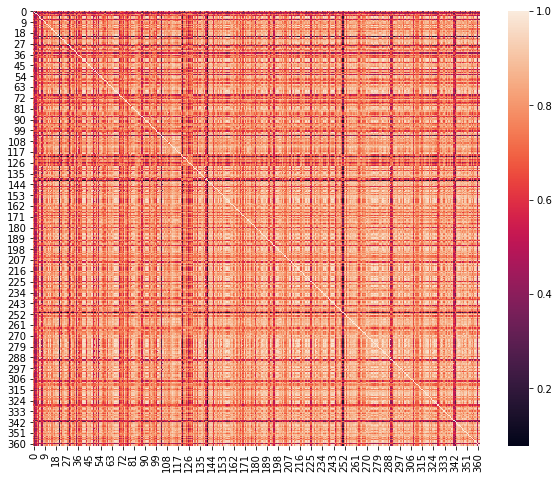

In [19]:
# visualizing the matrix R
plt.figure(figsize=(10,8))
vis_R = sns.heatmap(R)

The following code finds the minimum, second minimum, the max, and the second max values in the correlation matrix. It also finds the locations of these values in the matrix, which will be used later.

In [20]:
print("min value is", np.min(R)) # finding min value
np.where(R==np.min(R)) # finding min vlaue location

min value is 0.07889551690466243


(array([251]), array([23]))

In [21]:
R_vector = np.sort(R.flatten())
print("second min value is", R_vector[2]) # finding second min value
np.where(R == R_vector[2]) # finding second min value location

second min value is 0.08181707747291173


(array([21, 28]), array([28, 21]))

In [22]:
R_copy_max = R.copy()
np.fill_diagonal(R_copy_max, -1)
print("max value is", np.max(R_copy_max)) # finding max value
np.where(R_copy_max == np.max(R_copy_max)) # finding max value location

max value is 0.9966779932446087


(array([235, 283]), array([283, 235]))

In [23]:
R_copy_max_vector = np.sort(R_copy_max.flatten())
print("second max value is", R_copy_max_vector[-3]) # finding second max value
np.where(R_copy_max == R_copy_max_vector[-3]) # finding second max value location

second max value is 0.9958828102499753


(array([101, 243]), array([243, 101]))

Now, the `all_smooth` dictionary is used to find the ids and the names of the players with lowest and highest similarities. 

In [24]:
# finding the players corresponding to the max and min values
all_smooth_keys = list(all_smooth.keys()) # keys are playerids (organized by ordered value)

In [25]:
# finding the pair with lowest similarity
print(all_smooth_keys[np.where(R==np.min(R))[0][0]]) # player id
print(all_smooth_keys[np.where(R==np.min(R))[1][0]]) # player id
print(players.loc[all_smooth_keys[np.where(R==np.min(R))[0][0]]][1]) # player name
print(players.loc[all_smooth_keys[np.where(R==np.min(R))[1][0]]][1]) # player name

203584
2733
Troy Daniels
Shaun Livingston


In [26]:
# finding the pair with second to lowest similarity
print(all_smooth_keys[np.where(R == R_vector[2])[0][0]])
print(all_smooth_keys[np.where(R == R_vector[2])[0][1]])
print(players.loc[all_smooth_keys[np.where(R == R_vector[2])[0][0]]][1])
print(players.loc[all_smooth_keys[np.where(R == R_vector[2])[0][1]]][1])

2594
2744
Kyle Korver
Al Jefferson


In [27]:
# finding the pair with second to highest similarity
print(all_smooth_keys[np.where(R_copy_max == R_copy_max_vector[-3])[0][0]])
print(all_smooth_keys[np.where(R_copy_max == R_copy_max_vector[-3])[0][1]])
print(players.loc[all_smooth_keys[np.where(R_copy_max == R_copy_max_vector[-3])[0][0]]][1])
print(players.loc[all_smooth_keys[np.where(R_copy_max == R_copy_max_vector[-3])[0][1]]][1])

201599
203512
DeAndre Jordan
Lucas Nogueira


In [28]:
# finding the pair with highest similarity
print(all_smooth_keys[np.where(R_copy_max == np.max(R_copy_max))[0][0]])
print(all_smooth_keys[np.where(R_copy_max == np.max(R_copy_max))[0][1]])
print(players.loc[all_smooth_keys[np.where(R_copy_max == np.max(R_copy_max))[0][0]]][1])
print(players.loc[all_smooth_keys[np.where(R_copy_max == np.max(R_copy_max))[0][1]]][1])

203497
203991
Rudy Gobert
Clint Capela


Using the above information we will plot the shooting patterns of these players.

In [29]:
selected_names = "Shaun Livingston|Troy Daniels|Kyle Korver|Al Jefferson|DeAndre Jordan|Lucas Nogueira|Rudy Gobert|Clint Capela"
selected = players[players.DISPLAY_FIRST_LAST.str.contains(selected_names)]
selected

,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH
PERSON_ID,,,,,,,,,,,,,
203991,"Capela, Clint",Clint Capela,1,2014,2018,clint_capela,1610612745,Houston,Rockets,HOU,rockets,Y,01
203584,"Daniels, Troy",Troy Daniels,1,2013,2018,troy_daniels,1610612763,Memphis,Grizzlies,MEM,grizzlies,Y,01
203497,"Gobert, Rudy",Rudy Gobert,1,2013,2018,rudy_gobert,1610612762,Utah,Jazz,UTA,jazz,Y,01
2744,"Jefferson, Al",Al Jefferson,1,2004,2017,al_jefferson,1610612754,Indiana,Pacers,IND,pacers,Y,00
201599,"Jordan, DeAndre",DeAndre Jordan,1,2008,2018,deandre_jordan,1610612746,LA,Clippers,LAC,clippers,Y,00
2594,"Korver, Kyle",Kyle Korver,1,2003,2018,kyle_korver,1610612739,Cleveland,Cavaliers,CLE,cavaliers,Y,00
2733,"Livingston, Shaun",Shaun Livingston,1,2004,2018,shaun_livingston,1610612744,Golden State,Warriors,GSW,warriors,Y,01
203512,"Nogueira, Lucas",Lucas Nogueira,1,2014,2017,lucas_nogueira,1610612761,Toronto,Raptors,TOR,raptors,Y,01


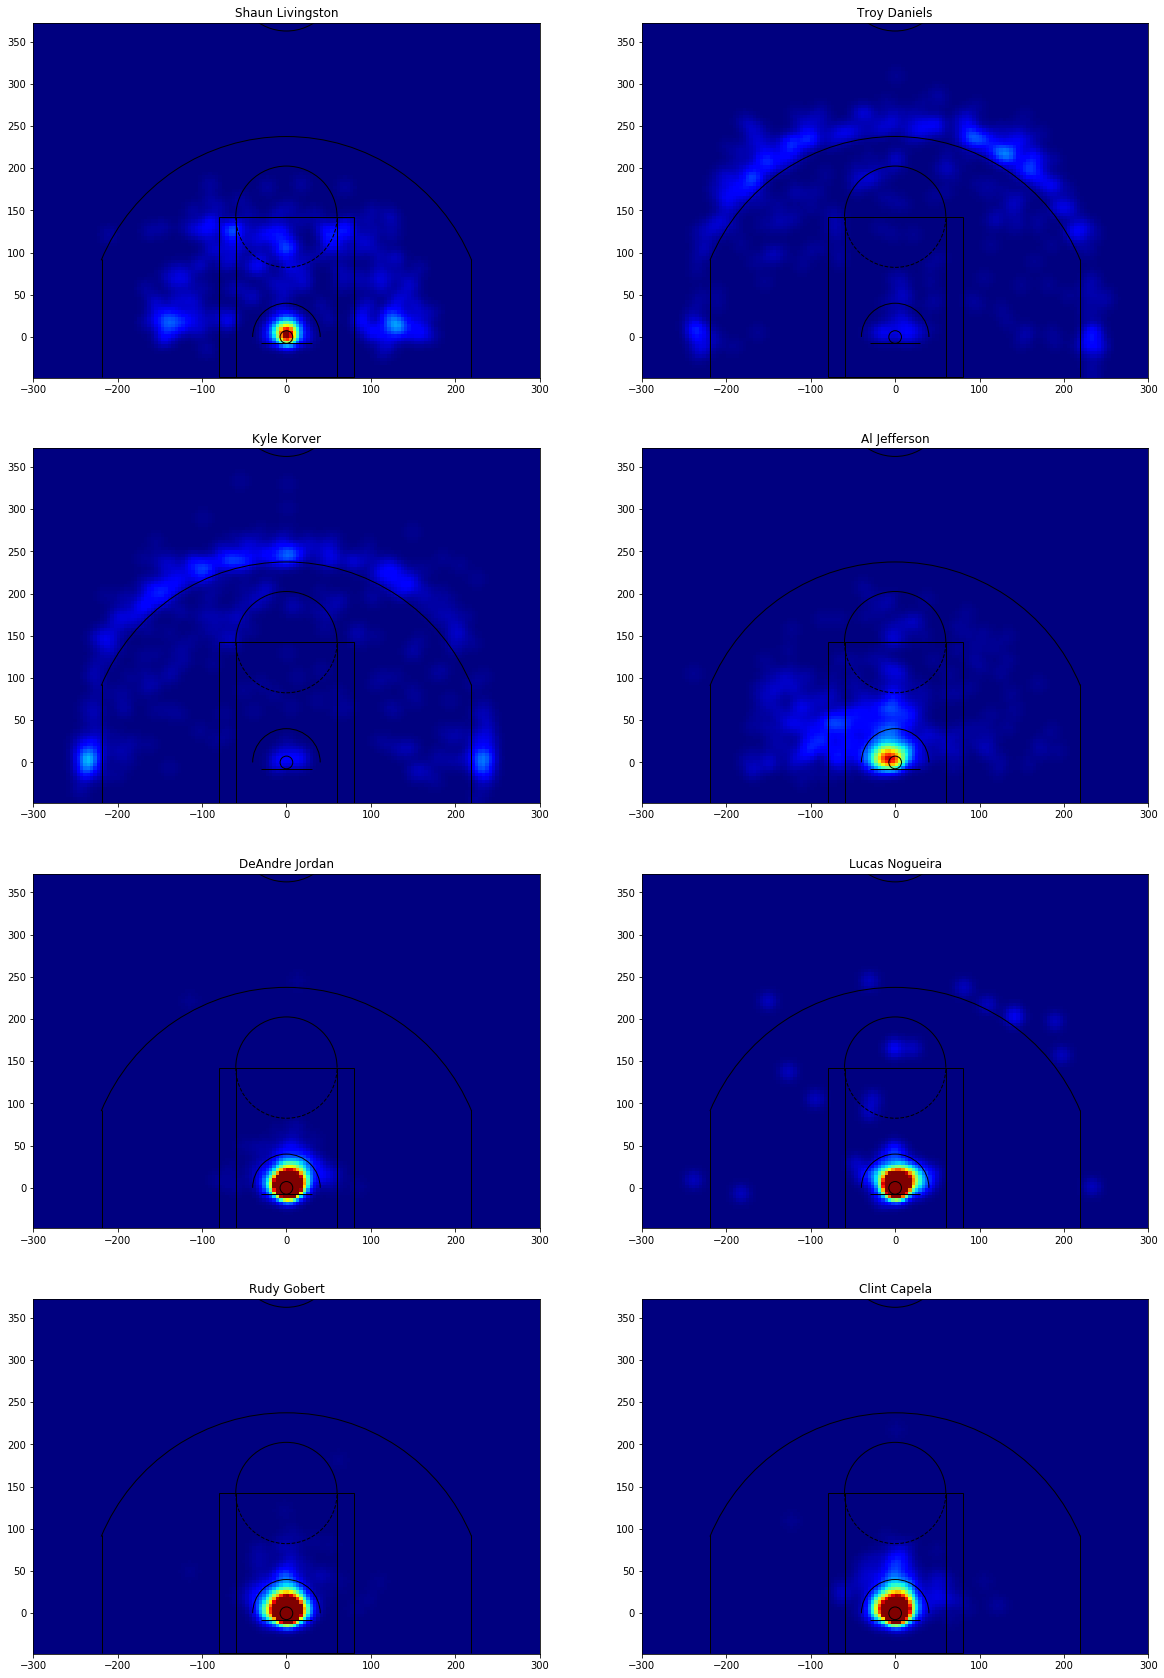

In [30]:
# create figure and axes
order = [2733, 203584, 2594, 2744, 201599, 203512, 203497, 203991] # getting pairs together
fig, ax = plt.subplots(4, 2, figsize=(20,30)) # creating plot setup

for axi, i in enumerate([0,2,4,6]):
    h.plot_shotchart(all_smooth[order[i]], xedges, yedges, ax=ax[axi,0])
    h.plot_shotchart(all_smooth[order[i+1]], xedges, yedges, ax=ax[axi,1])
    
    ax[axi,0].set_title(players.DISPLAY_FIRST_LAST[order[i]])
    ax[axi,1].set_title(players.DISPLAY_FIRST_LAST[order[i+1]])

The correlation matrix tells us that the players with the least similar shooting patterns are Shaun Livingston and Troy Daniels. The next players with the least similar shooting patterns are Kyle Korver and Al Jefferson. The players with the most similar shooting patterns are Rudy Gobert and Clint Capela. And the next players with the most similar shooting patterns are DeAndre Jordan and Lucas Nogueira. This is illustrated when looking at the above plots comparing these pairs. We see that the first pair has shooting patterns that are almost opposite while the next pair shows the same. When looking at the third row, the players shooting patterns are very similar. And in the last row, these pairs have extremely similar patterns.

### Differentiating between the types of players

Each column of the coefficients matrix $H$ gives a coefficent for each of the r-base vectors in $W$, where each column of $H$ aligns with a distinct player. Each of their coefficients represents how important each of the bases (columns of $W$) are. Thus, players with similar patterns will have similar weights on their bases (they will have similar coefficients). One could effectively use this coefficient matrix to group the players into similar player types by looking at the columns (since each column represents a player). The following code will illustrate this process by using the $H$ matrix to group the players into their corresponding types through hierarchical clustering. Note that $H$ will be transposed since the linkage function treats rows as the variables. $H$ is also standardized so that the players can be compared properly.

In [31]:
# getting cleaner looking data
players_coeff = pd.DataFrame(H, columns=players.DISPLAY_FIRST_LAST[all_smooth.keys()])

# standardizing players (want them to sum to 1)
players_coeff /= players_coeff.sum(0)
players_coeff.T.head()

,0,1,2,3,4,5,6,7,8,9
DISPLAY_FIRST_LAST,,,,,,,,,,
Vince Carter,0.133619,0.276993,0.076125,0.025535,0.044172,0.055318,0.105246,0.019991,0.171706,0.091296
Dirk Nowitzki,0.037934,0.020050,0.016393,0.064645,0.016547,0.000000,0.000000,0.445933,0.372290,0.026207
Jason Terry,0.126110,0.119487,0.024717,0.000000,0.041366,0.223974,0.043386,0.000000,0.014250,0.406709
Manu Ginobili,0.082592,0.270979,0.040975,0.243986,0.062188,0.033841,0.052955,0.021989,0.096109,0.094386
Jamal Crawford,0.000000,0.100515,0.104040,0.000000,0.099424,0.091580,0.122096,0.282061,0.151022,0.049261


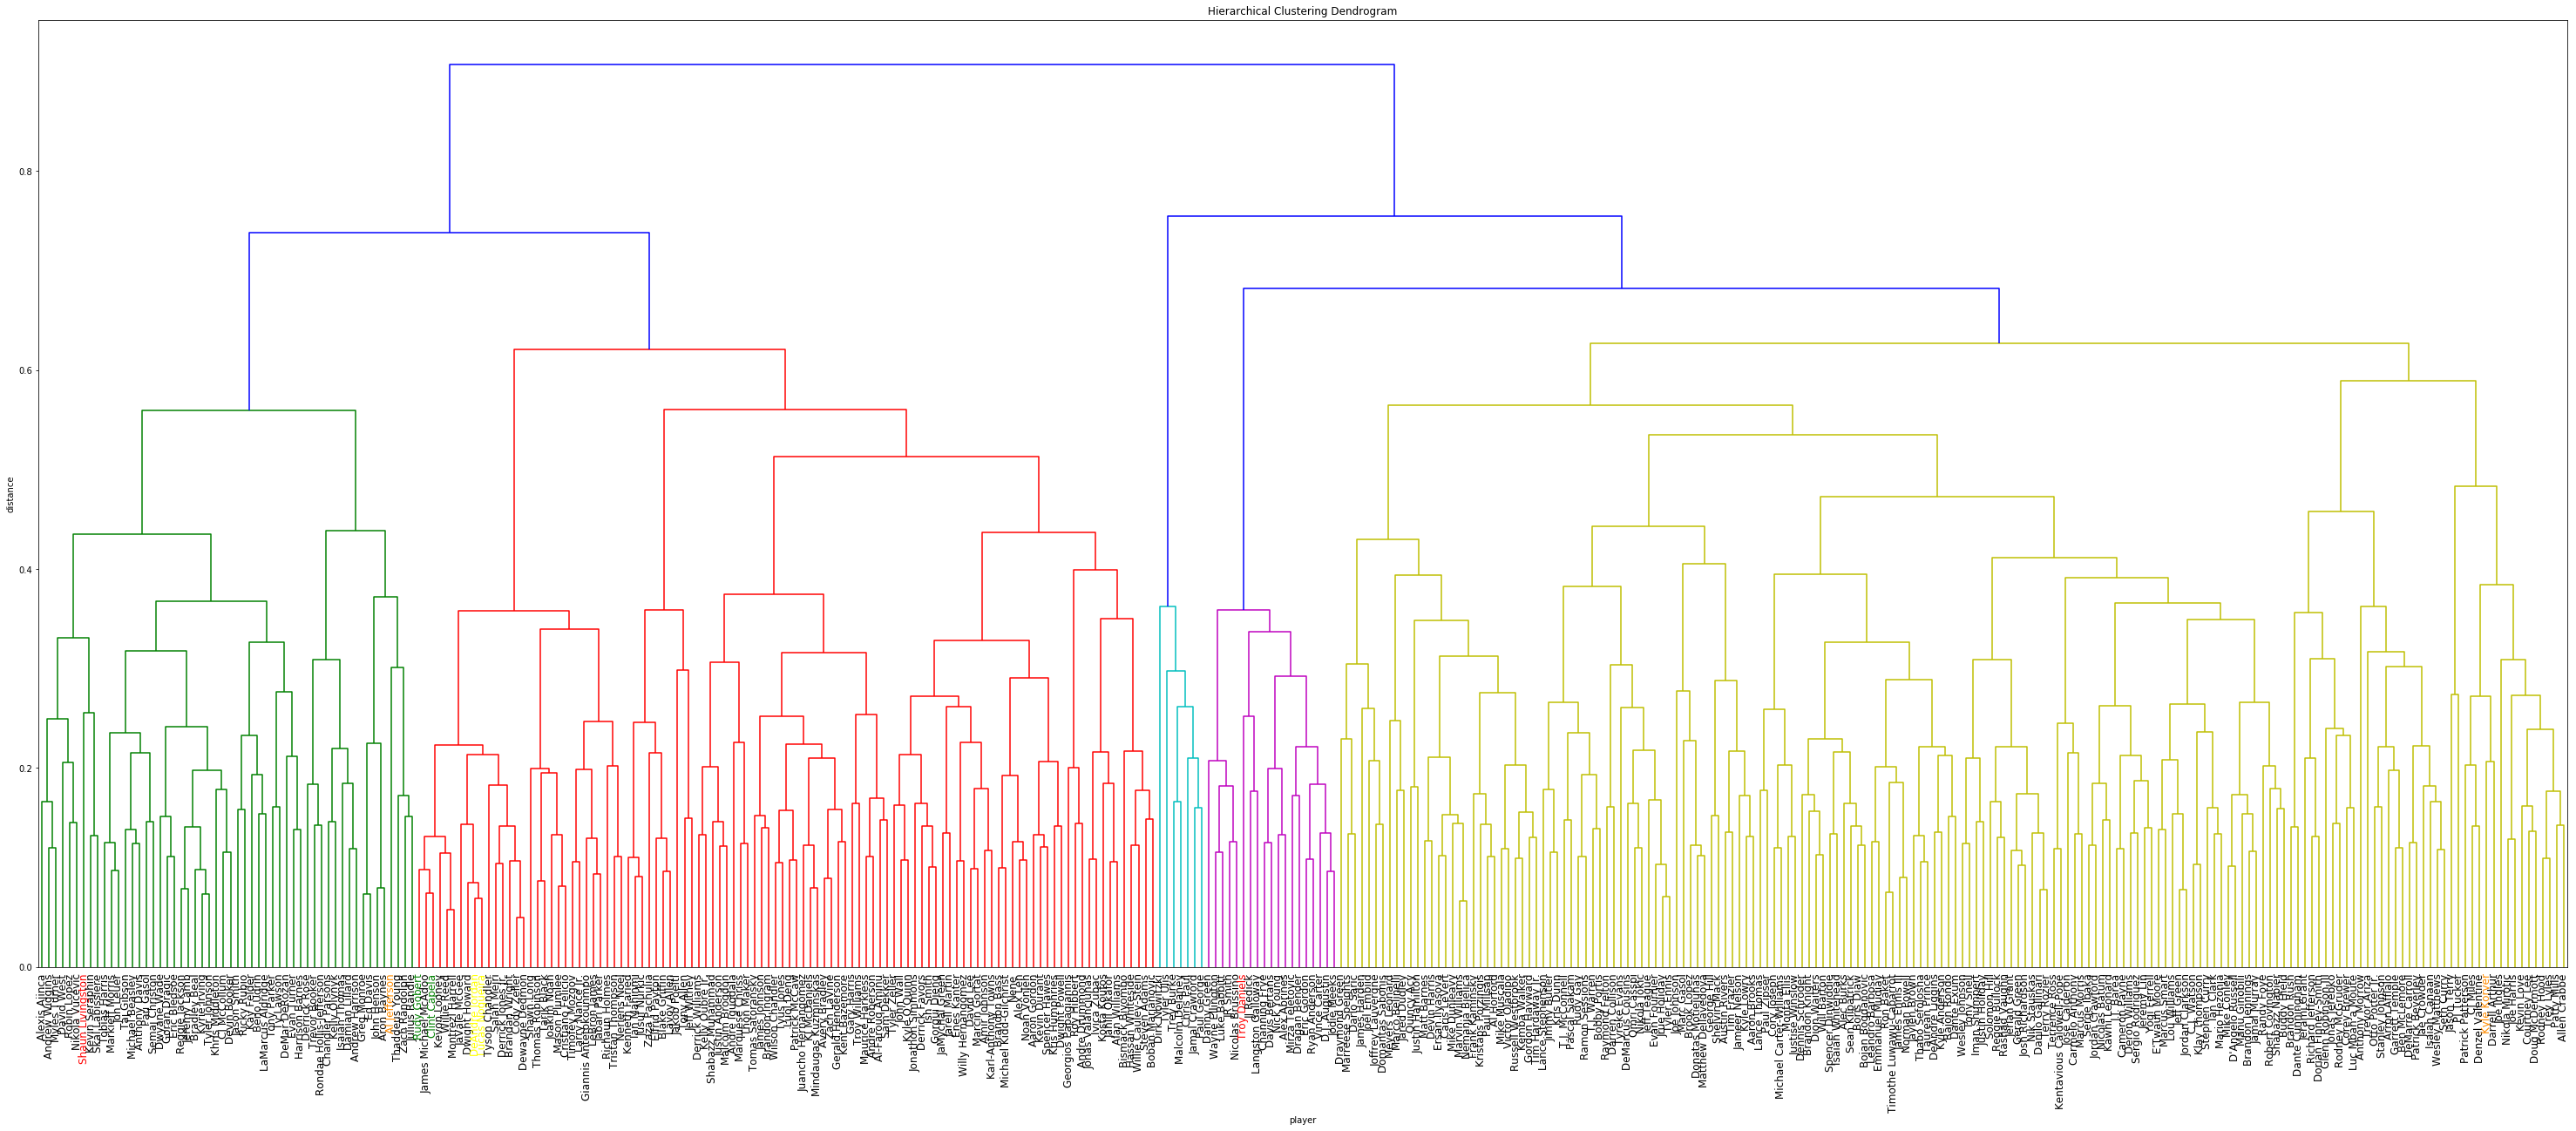

In [32]:
# defining linkage type
Z = linkage(players_coeff.T, method='complete', metric='euclidean')

# plotting the dendogram
plt.figure(figsize=(52,20))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel('player')
plt.ylabel('distance')
dendro = dendrogram(
            Z,
            leaf_rotation=90.,  # rotates the x axis labels
            leaf_font_size=12.,  # font size for the x axis labels
            labels = np.array(players.DISPLAY_FIRST_LAST[all_smooth.keys()])
)

# getting list of player ticks
player_ticks = dendro['ivl']

# coloring the pairs
troy_loc = list(player_ticks).index('Troy Daniels')
plt.gca().get_xticklabels()[troy_loc].set_color('r')
shaun_loc = list(player_ticks).index('Shaun Livingston')
plt.gca().get_xticklabels()[shaun_loc].set_color('r')

kyle_loc = list(player_ticks).index('Kyle Korver')
plt.gca().get_xticklabels()[kyle_loc].set_color('darkorange')
al_loc = list(player_ticks).index('Al Jefferson')
plt.gca().get_xticklabels()[al_loc].set_color('darkorange')

deandre_loc = list(player_ticks).index('DeAndre Jordan')
plt.gca().get_xticklabels()[deandre_loc].set_color('yellow')
lucas_loc = list(player_ticks).index('Lucas Nogueira')
plt.gca().get_xticklabels()[lucas_loc].set_color('yellow')

rudy_loc = list(player_ticks).index('Rudy Gobert')
plt.gca().get_xticklabels()[rudy_loc].set_color('g')
clint_loc = list(player_ticks).index('Clint Capela')
plt.gca().get_xticklabels()[clint_loc].set_color('g')

plt.show()

The hierarchical clustering above used complete linkage (which takes maximal intercluster dissimilarity into account by taking the largest of disimilarities). The measure of similarity used here was euclidean distance, since we we are looking at standardized values and are most concerned with which players have the same coefficient vectors.

By looking at our graph, we can see how the different players (the most different marked red and second most different marked orange) are in different clusters and seperated early on, as expected. Futhermore, we see that the similar players (the most similar marked green and second most similar marked yellow) are in the same clusters and more importantly we see that their branches split off near the very end, illustrating how closely each pair is grouped.

There seems to be about five main shooting types. This doesn't seem like a stretch because, for example, you could classify the players by those who mainly shoot from the center area, those who shoot further back right, and then futher back left, closer to the front right, and closer to the front left. 

This clustering comparison seems to be a little similar to the figures shown [here](https://fastbreakdata.com/classifying-the-modern-nba-player-with-machine-learning-539da03bb824). It is not expected to be completely similar though, because the data presented there uses more than just shooting patterns to classify the types of players (note we have a very offensive approach, the defensive nature of a player is hardly a concern here). There, it may depend on how much the shooting pattern of a specific player impacts the final clustering (i.e. is a player's shooting pattern an important feature?). Under the assumption that the position of a player has an impact on where/how the player shoots, specific types of players found in the linked page above may be grouped under the main shooting types that we have clustered here. This seems to be intuitively true as one would expect players in the same position to shoot similarly.

### Further analysis
This information could be used to place the players into positions where they will have more opportunity to be in position to make their shots according to their shooting pattern. For example, players who shoot mostly right under the hoop would be better to have in the front of the forwards. Whereas those who shoot left should be placed on the left side. More importantly, it can help with putting players into positions relative to one another. You might not want all players in one shooting group to be in at the same time. Instead, it would be better to have a more diverse team out on the court at any given time. 

This data could also be reanalyzed using a player's successful shot percentages to determine positioning on a player by player basis using the shooter type groupings. We could analyze not only where the player takes most of their shots but where the player makes most of their shots. We know player A, player B, and player C have similar shooting patterns, but player B makes more of their shots, thereby proving to be a lesser risk. Then, adding in the successful shot ratio per quarter on top could also tell us which players do better in which quarter. With this information we could decide which players we want in at certain times as the game goes on. For example, a player who makes more successful shots in the first half would be best placed in the first half of the game. And those players that seem to do well as time goes on should be put in towards the end of the game. Further analysis and manipulation can make for more detailed and intensive player positioning.

### References
For parameter specifications see [Endpoint Documentation](https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation).  
For shots data retrieval process in `shooting_patterns.ipynb` refer to [arXiv:1401.0942](https://arxiv.org/abs/1401.0942).  
Special thanks to Professor Sang-Yun Oh at UCSB for initial definitions in `helper_basketball.py` and guidance throughout the project.